## SingleRun + DepthCriterion

This notebook provides an example of a simulation that takes a number of __sub_processes__, grouped in a __SequentialActivity__, that is __executed while a stop condition is not yet met__. In this case the elements of the sub_processes have __depth limitations__. A separate 'Minimum depth' criterion is defined for loading. 

For this example we work with the following sub processes:
* sailing empty
* loading
* sailing full
* unloading

#### 0. Import libraries

In [152]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd
import numpy as np

import openclsim.core as core
import openclsim.utils as utils
import openclsim.model as model
import openclsim.plot as plot
import openclsim.plugins as plugin

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

src_path = utils.find_src_path()
init_notebook_mode(connected=True)

In [153]:
import opentnsim.core

#### 1. Initialise simpy environment

In [154]:
# setup environment (simulation time needs to match the available weather data)
# - be aware that OpenCLSim assumes UTC as its timezone
simulation_start  = datetime.datetime(2018, 8, 1, 0, 0, tzinfo=datetime.timezone.utc)
my_env = simpy.Environment(initial_time=simulation_start.timestamp())

#### 2. Define object classes

In [155]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,  
        core.LoadingFunction,      # NB: LoadingFunction mixed in
        core.UnloadingFunction,    # NB: UnloadingFunction mixed in
#         opentnsim.core.VesselProperties,
    ),
    {},
)
# Todo: we should add vessel properties here so we can get draugth also (as a function of loading rate)

# create a TestMoveActivity object based on desired mixin classes
TestMoveActivity =  type(
    "TestMoveActivity",
    (
        plugin.HasDepthPluginActivity,
        model.MoveActivity,  # the order is critical!
    ),
    {},
)

# create a TestShiftActivity object based on desired mixin classes
TestShiftActivity =  type(
    "TestShiftActivity",
    (
        plugin.HasDepthPluginActivity,
        model.ShiftAmountActivity,  # the order is critical!
    ),
    {},
)
# Todo: how can I add loading rates as a function of available depth

#### 3. Create objects
##### 3.1. Create site object(s)

In [156]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "capacity": 500_000,
                  "level": 500_000
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

# prepare input data for to_site
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "capacity": 500_000,
                "level": 0
               }
# instantiate to_site 
to_site = Site(**data_to_site)

##### 3.2. Create vessel object(s)

In [157]:
# prepare input data for vessel_01
data_vessel01 = {"env": my_env,
                 "name": "vessel01",
                 "geometry": location_from_site, 
                 "loading_rate": 5.5555,
                 "unloading_rate": 2.7777,
                 "capacity": 20_000,
                 "compute_v": lambda x: 3,
#                  "type": 'a',
#                  "B": 11,
#                  "L": 135,
#                  "T": 2.5,
               }
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)

In [158]:
20000/7200

2.7777777777777777

In [159]:
vessel01.__dict__

{'unloading_rate': 2.7777,
 'unload_manoeuvring': 0,
 'loading_rate': 5.5555,
 'load_manoeuvring': 0,
 'geometry': <shapely.geometry.point.Point at 0x1e807eb0430>,
 'wgs84': Geod(ellps='WGS84'),
 'env': <simpy.core.Environment at 0x1e8083edd90>,
 'resource': <simpy.resources.resource.Resource at 0x1e80846fc10>,
 'container': <openclsim.core.events_container.EventsContainer at 0x1e80846fe50>,
 'v': 1,
 'compute_v': <function __main__.<lambda>(x)>,
 'log': {'Timestamp': [],
  'ActivityID': [],
  'ActivityState': [],
  'ObjectState': [],
  'ActivityLabel': []},
 'name': 'vessel01',
 'id': '91556b5a-c6d8-4766-b4e1-e57d35de5a65'}

##### 3.3 Create activity/activities

In [160]:
# generate a dataframe with depth data
df = pd.DataFrame({'Year': [], 'Month': [], 'Day': [], 'Hour': [], 'Time': [], 'Minimum depth': [], 'ts': []})
Year = 2018
Month = 8

# create two lists  with college id and name
Days = 24*[1] + 24*[2] + 24*[3] + 24*[4] + 24*[5] + 24*[6] + 24*[7] + 24*[8] + 24*[9] 
Hours = 9*list(range(0,24))
  
# zip the two lists using zip() function
DayHours = list(zip(Days, Hours))

for DayHour in DayHours:
    Time = str(DayHour[0]).zfill(2) + '-' + str(Month).zfill(2) + '-' + str(Year).zfill(4) + ' ' + str(DayHour[1]).zfill(2) + ':' + str(0).zfill(2)  
    df.loc[len(df.index)] = [Year, Month, DayHour[0], DayHour[1], Time, 
                             np.sin(1/12* DayHour[1] * np.pi) + 1.5, 
                             datetime.datetime(Year, Month, DayHour[0], DayHour[1]).timestamp()]    

df = df.set_index(pd.to_datetime(df["Time"], dayfirst=True))
df = df.sort_index()
df.head(10)

,Year,Month,Day,Hour,Time,Minimum depth,ts
Time,,,,,,,
2018-08-01 00:00:00,2018,8,1,0,01-08-2018 00:00,1.500000,1.533074e+09
2018-08-01 01:00:00,2018,8,1,1,01-08-2018 01:00,1.758819,1.533078e+09
2018-08-01 02:00:00,2018,8,1,2,01-08-2018 02:00,2.000000,1.533082e+09
2018-08-01 03:00:00,2018,8,1,3,01-08-2018 03:00,2.207107,1.533085e+09
2018-08-01 04:00:00,2018,8,1,4,01-08-2018 04:00,2.366025,1.533089e+09
2018-08-01 05:00:00,2018,8,1,5,01-08-2018 05:00,2.465926,1.533092e+09
2018-08-01 06:00:00,2018,8,1,6,01-08-2018 06:00,2.500000,1.533096e+09
2018-08-01 07:00:00,2018,8,1,7,01-08-2018 07:00,2.465926,1.533100e+09
2018-08-01 08:00:00,2018,8,1,8,01-08-2018 08:00,2.366025,1.533103e+09


<AxesSubplot:xlabel='Time', ylabel='Minimum depth [m]'>

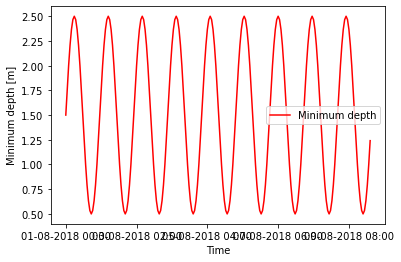

In [161]:
df.plot(kind='line',x='Time',y='Minimum depth',color='red', ylabel='Minimum depth [m]')

In [162]:
# generate a depth criterion for the sailing process
sailing_crit = plugin.DepthCriterion(
    name="sailing_crit",
    condition="Minimum depth",
    minimum=1, # for now we assume that 1 m waterdepth is the minimum depth for economic accomodation of draught + ukc + margin
    window_length=3600,
)

# generate a depth criterion for the loading process
loading_crit = plugin.DepthCriterion(
    name="loading_crit",
    condition="Minimum depth",
    minimum=1, # for now we assume that 1 m waterdepth is the minimum depth for economic accomodation of draught + ukc + margin
    window_length=3600,
)
# Todo: we should look at the minimum depth for a window as long as the sailing trip (and then make sure we load accordingly)

In [163]:
# initialise registry
registry = {}

In [164]:
# create a list of the sub processes
sub_processes = [
    TestMoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=vessel01,
        destination=from_site,
        depth_criteria=sailing_crit,
        depth_df=df,
    ),
    TestShiftActivity(
        env=my_env,
        name="loading",
        registry=registry,
        origin=from_site,
        destination=vessel01,
        processor=vessel01,
        phase="loading",
        depth_criteria=loading_crit,
        depth_df=df,
    ),
    TestMoveActivity(
        env=my_env,
        name="sailing full",
        registry=registry,
        mover=vessel01,
        destination=to_site,
        depth_criteria=sailing_crit,
        depth_df=df,
    ),
    TestShiftActivity(
        env=my_env,
        name="unloading",
        registry=registry,
        origin=vessel01,
        destination=to_site,
        processor=vessel01,
        phase="unloading",
        depth_criteria=loading_crit,
        depth_df=df,
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity = model.SequentialActivity(
    env=my_env,
    name="sequential_activity_subcycle",
    registry=registry,
    sub_processes=sub_processes,
)

# create a while activity that executes the 'sequential activity' while the stop condition is not triggered 
while_activity = model.WhileActivity(
    env=my_env,
    name="while_sequential_activity_subcycle",
    registry=registry,
    sub_processes=[sequential_activity],
    condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
)

#### 4. Register processes and run simpy

In [165]:
# initate the simpy processes defined in the 'while activity' and run simpy
model.register_processes([while_activity])
my_env.run()

#### 5. Inspect results
##### 5.1 Inspect logs

In [166]:
plot.get_log_dataframe(while_activity, [while_activity]).head()

,Activity,Timestamp,ActivityState,type,ref
0,while_sequential_activity_subcycle,2018-08-01 00:00:00.000000,START,NaN,NaN
1,while_sequential_activity_subcycle,2018-08-01 00:00:00.000000,START,subprocess,26dd3faa-539a-4103-948e-9c560d2b7124
2,while_sequential_activity_subcycle,2018-08-01 03:52:22.986243,STOP,subprocess,26dd3faa-539a-4103-948e-9c560d2b7124
3,while_sequential_activity_subcycle,2018-08-01 03:52:22.986243,START,subprocess,26dd3faa-539a-4103-948e-9c560d2b7124
4,while_sequential_activity_subcycle,2018-08-01 08:37:08.721125,STOP,subprocess,26dd3faa-539a-4103-948e-9c560d2b7124


In [167]:
plot.get_log_dataframe(sub_processes[1], [while_activity]).head()

,Activity,Timestamp,ActivityState,type,ref
0,loading,2018-08-01 00:00:00.000000,START,NaN,NaN
1,loading,2018-08-01 01:00:00.036000,STOP,NaN,NaN
2,loading,2018-08-01 04:44:45.734881,START,NaN,NaN
3,loading,2018-08-01 05:44:45.770881,STOP,NaN,NaN
4,loading,2018-08-01 09:29:31.469762,START,NaN,NaN


In [168]:
plot.get_log_dataframe(sub_processes[1], [while_activity]).head()

,Activity,Timestamp,ActivityState,type,ref
0,loading,2018-08-01 00:00:00.000000,START,NaN,NaN
1,loading,2018-08-01 01:00:00.036000,STOP,NaN,NaN
2,loading,2018-08-01 04:44:45.734881,START,NaN,NaN
3,loading,2018-08-01 05:44:45.770881,STOP,NaN,NaN
4,loading,2018-08-01 09:29:31.469762,START,NaN,NaN


##### 5.2 Visualise gantt charts

In [169]:
res = plot.get_gantt_chart([vessel01], y_scale="numbers", static=True, id_map=[while_activity])
data = res['data']
layout = res['layout']

data.append({
    "name": "sailing_crit",
    "x":[vessel01.log["Timestamp"][0].isoformat(), vessel01.log["Timestamp"][-1].isoformat()],
    "y":[sailing_crit.minimum,sailing_crit.minimum],
})

data.append({
    "name": "Depth",
    "x":df.index,
    "y":df[sailing_crit.condition],
})

data.append({
    "name": "loading_crit",
    "x":[vessel01.log["Timestamp"][0].isoformat(), vessel01.log["Timestamp"][-1].isoformat()],
    "y":[loading_crit.minimum,loading_crit.minimum],
})

go.Figure(data=data, layout=layout)

**_Some observations:_**
* For some reason loading appears to start 2 hours before the simulation starting time \[bug?\]
* The moving criterion states that sailing can only commence when Minimum depth is at minimum 1 m for a window of at least 3600 seconds. We see indeed that the plugin introduces waiting when water levels are too low. But it seems that at the end it missed one limiting depth window. 

In [170]:
plot.get_gantt_chart(sub_processes)

##### 5.3 Visualise container volume developments

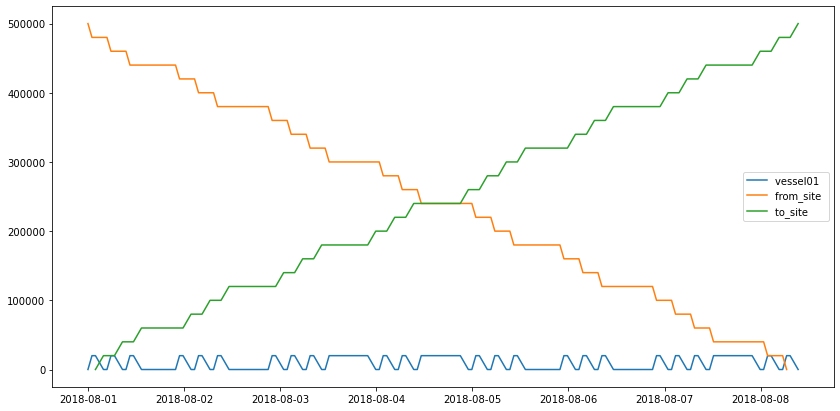

In [171]:
fig = plot.get_step_chart([vessel01, from_site, to_site])